In [1]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
from process import Process
import pandas as pd
from scipy import stats


In [2]:
image_path_left = './data/images/im0.png'
image_path_right = './data/images/im1.png'

In [3]:
imL = Process(image_path_left)
imL.resize_image(371, 250)
arrL = imL.get_array()
imL.get_info()

imR = Process(image_path_right)
imR.resize_image(371, 250)
arrR = imR.get_array()
imR.get_info()

Image size: (371, 250)
Image mode: L
Image size: (371, 250)
Image mode: L


((371, 250), 'L')

In [4]:
from scipy import ndimage

# activate for laplacian filter
arrL_filtered = ndimage.laplace(arrL)
arrR_filtered = ndimage.laplace(arrR)

array_left = arrL
array_right = arrR

In [5]:
"""
Calculate Disparity using Sum of Absolute Differences Method (SAD)
Region matching between windows in the left and right images using the SAD method. 
Modify 'size' and 'search_range' to alter results.
"""

size = 12

search_range = 50

start_time = time.time()

disp_matrix = []

for row in range(len(arrL_filtered) - size):

    if row % 10 == 0:
        print(f"{row} rows completed.")

    disps = []

    for col1 in range(len(arrL_filtered[row]) - size):
        win1 = arrL_filtered[row:row + size, col1:col1 + size].flatten()

        if col1 < search_range:
            init = 0
        else:
            init = col1 - search_range

        sads = []

        for col2 in range(col1, init - 1, -1):
            win2 = arrR_filtered[row:row + size, col2:col2 + size].flatten()

            sad = np.sum(np.abs(np.subtract(win1, win2)))
            sads.append(sad)

        disparity = np.argmin(sads)
        disps.append(disparity)

    disp_matrix.append(disps)
            
        
disp_matrix = np.array(disp_matrix)

end_time = time.time()

print(f"Total runtime: {end_time - start_time}")
print(disp_matrix.shape)

0 rows completed.
10 rows completed.
20 rows completed.
30 rows completed.
40 rows completed.
50 rows completed.
60 rows completed.
70 rows completed.
80 rows completed.
90 rows completed.
100 rows completed.
110 rows completed.
120 rows completed.
130 rows completed.
140 rows completed.
150 rows completed.
160 rows completed.
170 rows completed.
180 rows completed.
190 rows completed.
200 rows completed.
210 rows completed.
220 rows completed.
230 rows completed.
Total runtime: 67.45992469787598
(238, 359)


In [6]:
"""
Image Calibration
"""

z_matrix = np.copy(disp_matrix)
baseline = 193.001
f = 3979.911
doffs = 124.343
for i in np.nditer(z_matrix):
    i = baseline * f / (i + doffs)

z_matrix

array([[ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       ...,
       [ 0,  0,  0, ..., 27, 27, 27],
       [ 0,  0,  0, ..., 27, 27, 27],
       [ 0,  0,  2, ..., 27, 27, 27]], dtype=int64)

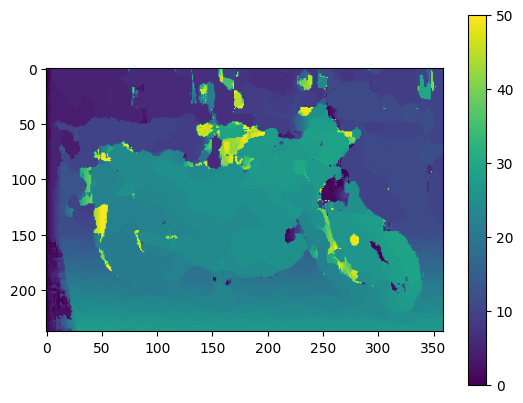

In [7]:
plt.imshow(disp_matrix)
plt.colorbar()

C:\Users\kents\anaconda3\envs\cv2024\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kents\anaconda3\envs\cv2024\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


38.81


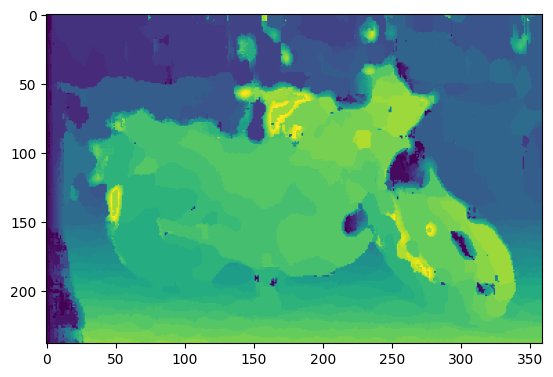

In [8]:
"""
Post-processing
"""
import math

raw_img = './data/images/im0.png'

img = Image.open(raw_img)
img = img.resize((disp_matrix.shape[1], disp_matrix.shape[0]))
arr = np.array(img)

xyzrgb = []

avg_disp = np.copy(disp_matrix)

avgList = []

for x in range(disp_matrix.shape[1]): # 238
    for y in range(disp_matrix.shape[0]): # 359

        # MEAN
        avg = np.mean(avg_disp[y-5:y+5, x-5:x+5])
        if (math.isnan(avg) == False):
            avgList.append(avg)
        if avg_disp[y, x] - avg > 5:
            avg_disp[y, x] = avg

        # THRESHOLD
        if avg_disp[y, x] > 34:
            avg_disp[y, x] = 29

        z = np.multiply(avg_disp[y, x], 6)
        rgb = arr[y, x]
        xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])

print(max(avgList))
df = pd.DataFrame(xyzrgb)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df.to_csv('./data/output/point_cloud.txt', index=False)
plt.imshow(avg_disp)
plt.savefig('./data/output/disp_MPL.png')